<Figure size 720x504 with 0 Axes>

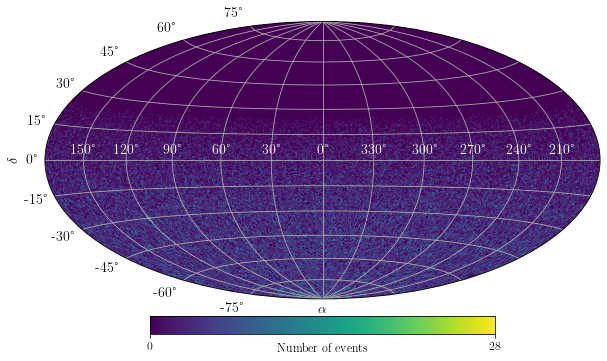

In [2]:
#---------------------------------------
# Try optimize the code!!!!
#---------------------------------------
import math
import numpy as np 
import healpy as hp
from healpy.newvisufunc import projview

#for plotting 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rc

#to import and work with data frames 
import pandas as pd

#to work with time and angular coordinates in the celeastial sphere
from astropy.time import Time

%matplotlib inline

rc('font',**{'family':'serif','serif':['DejaVu Sans']})
rc('text', usetex=True)

#convert a set of pandas columns into a list of event 
def pandas_to_event(df, str1 , str2, str3, str4):
    
    alpha = df[str1].to_numpy()
    delta = df[str2].to_numpy()
    time = df[str3].to_numpy()
    energy = df[str4].to_numpy()
    
    evt_list = []
    
    for i in range(len(alpha)):
        evt_list.append([alpha[i],delta[i],time[i],energy[i]])
        
    return evt_list

#convert equatorial coordinates of event into healpy coordinates 
def Healpy_Event(evt_list):
        
    new_evt_list = []
    
    for evt in evt_list:
        evt[1] = math.pi/2 - evt[1]
        new_evt_list.append(evt)
    
        
    return new_evt_list

#convert equatorial coordinates into healpy coordinates 
def ToHealpyCoordinates(alpha, dec):
    
    return alpha, np.pi/2 - dec

#convert healpy coordinates into Equatorial Coordinates
def ToEquatorialCoordinates(phi, theta):
    
    return phi, np.pi/2 - theta

#compute the 
#-------------------------------
# main 
#-------------------------------

#save dataframe with event info from csv file
path = '../DataSets/MockData_Repeaters/'
filename = 'TimeOrdered_Events_ExponentialRepeater_Date_2015-01-01T00:00:00_Period_86164_TotalEvents_100000_AcceptedRepEvents_100.parquet'

uniform_dist_data = pd.read_parquet(path + filename, engine='fastparquet') 

#convert dataframe into a list of events
uniform_dist_events = pandas_to_event(uniform_dist_data,"rep_ud_ra", "rep_ud_dec","rep_ud_gpstime","rep_ud_energy")    

#change delta into colatitude to project in sky
hp_ud_events = Healpy_Event(uniform_dist_events)


#12*nside*nside gives the number of pixels of sphere 
NSIDE = 64
            
#vector with index positions in healpy sky_map given theta and phi
cr_sky_indexes = [] 

#vector to hold events. If the event is accepted, the vector is field with 1, otherwise it is filed with 0
events = []

#run over the events 
for evt in hp_ud_events:
    
    cr_sky_indexes.append(hp.ang2pix(NSIDE,evt[1],evt[0]))
    events.append(1)

#count map for each event: vector with size npix and filled with 0s
instant_cr_sky = np.zeros(hp.nside2npix(NSIDE))

#subsitutes zeros in the pixel indices for their bin content, given the data
np.add.at(instant_cr_sky, cr_sky_indexes, events)

#create figure
fig = plt.figure(figsize=(10,7)) #create figure

#plot sky map 
projview(
    instant_cr_sky,
    graticule=True,
    graticule_labels=True,
    #title=r"Instantaneous exposure for " + str(theta_min) + r"$^\circ < \theta < $ " + str(theta_max) + r"$^\circ$ on " + str(t.fits),
    unit="Number of events",
    xlabel=r"$\alpha$",
    ylabel=r"$\delta$",
    cb_orientation="horizontal",
    projection_type="hammer",
    fontsize={'title':16, 'xlabel':14, 'ylabel':14, 'xtick_label':14, 'ytick_label':14},
    longitude_grid_spacing = 30,
    latitude_grid_spacing = 15,
    xtick_label_color='white'
)

plt.savefig('skymap_repeater.pdf',dpi=500)



<Figure size 720x504 with 0 Axes>

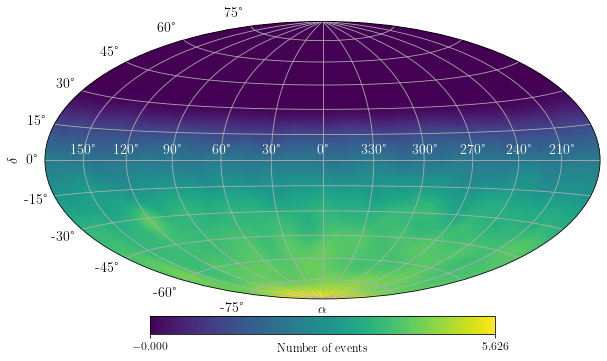

In [3]:
smoothing_radius = np.radians(10)

smooth_sky_map = hp.smoothing(instant_cr_sky, sigma=0.5*smoothing_radius)

#create figure
fig_smooth = plt.figure(figsize=(10,7)) #create figure

#plot sky map 
projview(
    smooth_sky_map,
    graticule=True,
    graticule_labels=True,
    #title=r"Instantaneous exposure for " + str(theta_min) + r"$^\circ < \theta < $ " + str(theta_max) + r"$^\circ$ on " + str(t.fits),
    unit="Number of events",
    xlabel=r"$\alpha$",
    ylabel=r"$\delta$",
    cb_orientation="horizontal",
    projection_type="hammer",
    fontsize={'title':16, 'xlabel':14, 'ylabel':14, 'xtick_label':14, 'ytick_label':14},
    longitude_grid_spacing = 30,
    latitude_grid_spacing = 15,
    xtick_label_color='white'
)

plt.savefig('smooth_sky_map_repeater.pdf',dpi=500)

67538.46442892587


<Figure size 720x504 with 0 Axes>

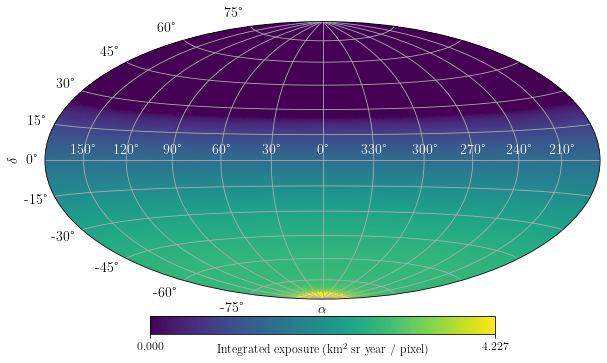

In [4]:
#compute the total exposure and the integrated exposure per solid angle
def integrated_exposure(theta_min, theta_max, a_cell, time_begin, time_end, time, station_array):

    #to select only the stations within the time period time_begin < time < time_end
    time_indexes = np.where(np.logical_and(time > time_begin, time < time_end))[0]

    return (math.pi/2)*(math.cos(2*theta_min) - math.cos(2*theta_max))*a_cell*sum(station_array[time_indexes])

#compute the relative exposure per solid angle
def relative_exposure(dec, lat_auger, theta_min, theta_max):
    
        
    xi = (math.cos(theta_max) - math.sin(lat_auger)*math.sin(dec))/(math.cos(lat_auger)*math.cos(dec))
    
    if ( xi > 1):
        h_max = 0
    elif (xi < -1):
        h_max = math.pi
    else:
        h_max = math.acos(xi)
        
    return math.cos(lat_auger)*math.cos(dec)*math.sin(h_max) + h_max*math.sin(lat_auger)*math.sin(dec)

#read the relavant info from the event selection files 
selection_info_file = 'Selection_event_info_Date_2015-01-01T00:00:00_Period_86164_TotalEvents_100000_AcceptedRepEvents_100.parquet'
selection_info = pd.read_parquet(path + selection_info_file, engine='fastparquet')

#latitude and longitude of the Pierre Auger Observatory
lat_auger = math.radians(-35.23)

#values of the maximum and minimum values of theta. In this case we are considering vertical events
theta_min = math.radians(0)
theta_max = float(selection_info['Theta_max'].to_numpy()[0])

#set value of unit cell of array according to distance between stations
d = 1.5 #in kilometers
a_cell = .5*math.sqrt(3)*d*d

#set time interval in seconds
time_begin = Time(selection_info['t_begin'].to_numpy()[0], format='fits').gps
time_end = Time(selection_info['t_end'].to_numpy()[0], format='fits').gps

#load station data
station_data = pd.read_parquet('../DataSets/Auger_Hexagons/Hexagons_NoBadStations.parquet', engine='fastparquet')

time = station_data['gps_time'].to_numpy()
n5T5 = station_data['n5T5'].to_numpy()
n6T5 = station_data['n6T5'].to_numpy()

#compute time integrated exposure
total_exposure = integrated_exposure(theta_min, theta_max, a_cell, time_begin, time_end, time, (2/3)*n5T5 + n6T5)/(365*24*60) #per year per sr per km^2

print(total_exposure)

#get the angles of each pixel in skymap 
exp_theta, exp_phi = hp.pix2ang(NSIDE, np.arange(hp.nside2npix(NSIDE)))

exp_alpha, exp_dec = ToEquatorialCoordinates(exp_phi, exp_theta)

exp_map_indexes = []
exp_map_content = []

for i in range(len(exp_phi)):
    
    exp_map_indexes.append(hp.ang2pix(NSIDE, exp_theta[i], exp_phi[i]))
    exp_map_content.append(relative_exposure(exp_dec[i],lat_auger, theta_min, theta_max))

#produce vector with 0's
exp_skymap = np.zeros(hp.nside2npix(NSIDE))

np.add.at(exp_skymap, exp_map_indexes, np.multiply(exp_map_content, total_exposure/sum(exp_map_content)))

#create figure
fig = plt.figure(figsize=(10,7)) #create figure

#plot sky map 
projview(
    exp_skymap,
    graticule=True,
    graticule_labels=True,
    #title=r"Instantaneous exposure for " + str(theta_min) + r"$^\circ < \theta < $ " + str(theta_max) + r"$^\circ$ on " + str(t.fits),
    unit=r"Integrated exposure (km$^2$ sr year / pixel)",
    xlabel=r"$\alpha$",
    ylabel=r"$\delta$",
    cb_orientation="horizontal",
    projection_type="hammer",
    fontsize={'title':16, 'xlabel':14, 'ylabel':14, 'xtick_label':14, 'ytick_label':14},
    longitude_grid_spacing = 30,
    latitude_grid_spacing = 15,
    xtick_label_color='white'
)

plt.savefig('Integrated_exposure_sky_map_repeater.pdf',dpi=500)

<Figure size 720x504 with 0 Axes>

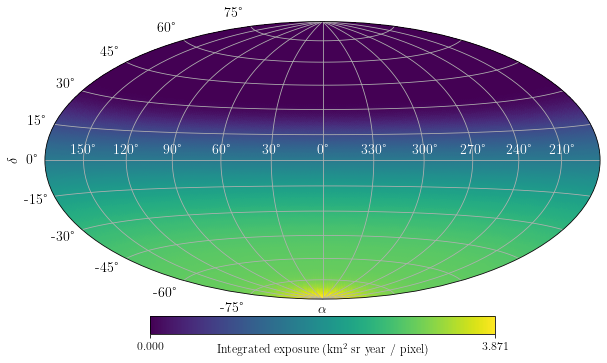

In [66]:
#smoothed exposure map 
smooth_exp_skymap = hp.smoothing(exp_skymap, sigma=0.5*smoothing_radius)

#create figure
fig_exp_smooth = plt.figure(figsize=(10,7)) #create figure

#plot sky map 
projview(
    smooth_exp_skymap,
    graticule=True,
    graticule_labels=True,
    #title=r"Instantaneous exposure for " + str(theta_min) + r"$^\circ < \theta < $ " + str(theta_max) + r"$^\circ$ on " + str(t.fits),
    unit=r"Integrated exposure (km$^2$ sr year / pixel)",
    xlabel=r"$\alpha$",
    ylabel=r"$\delta$",
    cb_orientation="horizontal",
    projection_type="hammer",
    fontsize={'title':16, 'xlabel':14, 'ylabel':14, 'xtick_label':14, 'ytick_label':14},
    longitude_grid_spacing = 30,
    latitude_grid_spacing = 15,
    xtick_label_color='white'
)

plt.savefig('smooth_exposure_sky_map_repeater.pdf',dpi=500)

<Figure size 720x504 with 0 Axes>

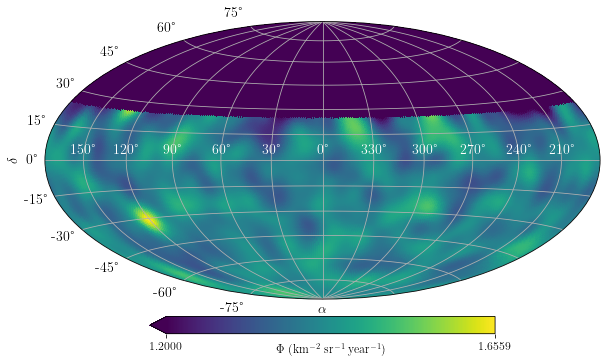

In [68]:
#produce the smoothed flux map assuming that, for each pixel, the flux reads N_events/exposure 

smooth_flux_sky_map = []

for i in range(len(smooth_sky_map)):
    if (exp_skymap[i] == 0):
        smooth_flux_sky_map.append(0)
    else:
        smooth_flux_sky_map.append(smooth_sky_map[i] / smooth_exp_skymap[i])
        
#tranform list into array
smooth_flux_sky_map = np.array(smooth_flux_sky_map)

#create figure
fig = plt.figure(figsize=(10,7)) #create figure

#plot sky map 
projview(
    smooth_flux_sky_map,
    graticule=True,
    graticule_labels=True,
    #title=r"Instantaneous exposure for " + str(theta_min) + r"$^\circ < \theta < $ " + str(theta_max) + r"$^\circ$ on " + str(t.fits),
    unit=r"$\Phi$ (km$^{-2}$ sr$^{-1}$ year$^{-1}$)",
    xlabel=r"$\alpha$",
    ylabel=r"$\delta$",
    cb_orientation="horizontal",
    min = 1.2,
    max = max(smooth_flux_sky_map),
    projection_type="hammer",
    fontsize={'title':16, 'xlabel':14, 'ylabel':14, 'xtick_label':14, 'ytick_label':14},
    longitude_grid_spacing = 30,
    latitude_grid_spacing = 15,
    xtick_label_color='white'
)

plt.savefig('smooth_flux_skymap_repeater.pdf',dpi=500)

<Figure size 720x504 with 0 Axes>

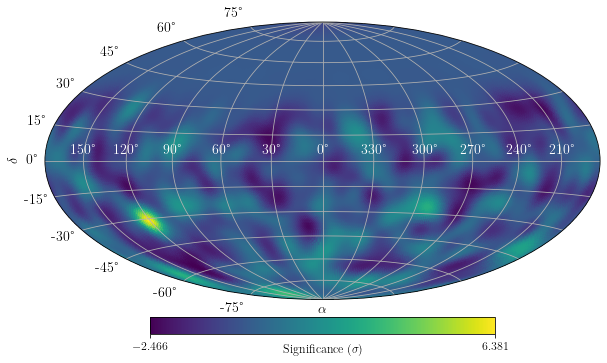

In [83]:
#produce the LI and MA significance map

def LiMaSignificance(alpha, N_on, N_off):
    
    log_N_on = (1. + alpha)*N_on / (alpha*(N_on + N_off))
    log_N_off = (1. + alpha)*N_off / (N_on + N_off)
    
    #to avoid negative values, induced by smoothing, in the arg of logs
    sig_2 = np.zeros(len(N_on))
    
    positive_indexes = np.where(np.logical_and(N_on > 0, alpha > 0))
    sig_2[positive_indexes] += N_on[positive_indexes]*np.log(log_N_on[positive_indexes])
    
    positive_indexes = np.where(N_off > 0)
    sig_2[positive_indexes] += N_off[positive_indexes]*np.log(log_N_off[positive_indexes])
              
    return np.sqrt(2*np.abs(sig_2))*np.sign(N_on - alpha*N_off)
              
#define the number of pixels per region 
region_solid_angle = 2*math.pi*(1 - math.cos(smoothing_radius))
solid_angle_per_pix = 4*math.pi / hp.nside2npix(NSIDE)
npix_per_region = region_solid_angle / solid_angle_per_pix
              
#define the alpha, N_on and N_off 
alpha = smooth_exp_skymap / (np.sum(exp_skymap) / npix_per_region - smooth_exp_skymap)
N_on = smooth_sky_map*npix_per_region 
N_off = np.sum(instant_cr_sky) - N_on 

#make the significance map 
significance_map = LiMaSignificance(alpha, N_on, N_off)

#create figure
fig = plt.figure(figsize=(10,7)) #create figure

#plot sky map 
projview(
    significance_map,
    graticule=True,
    graticule_labels=True,
    #title=r"Instantaneous exposure for " + str(theta_min) + r"$^\circ < \theta < $ " + str(theta_max) + r"$^\circ$ on " + str(t.fits),
    unit=r"Significance ($\sigma$)",
    xlabel=r"$\alpha$",
    ylabel=r"$\delta$",
    cb_orientation="horizontal",
    #max = max(significance_map),
    #min = -max(significance_map),
    projection_type="hammer",
    fontsize={'title':16, 'xlabel':14, 'ylabel':14, 'xtick_label':14, 'ytick_label':14},
    longitude_grid_spacing = 30,
    latitude_grid_spacing = 15,
    xtick_label_color='white'
)

plt.savefig('smooth_LiMa_significance_skymap_repeater.pdf',dpi=500)